#1.Training Process

## 1.1 Importing Required Libraries and Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import shutil, os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ssl, json, requests, io, urllib3
from pathlib import Path
from PIL import Image
from tensorflow.keras.models import load_model
!pip install -q gdown

## 1.2 Importing & Loading the dataset


In [ ]:
# --- Xóa các file zip và thư mục cũ nếu có ---
folders_to_remove = ["./dataset/train", "./dataset/test", "./dataset/validation"]
files_to_remove = ["train.zip", "test.zip", "validation.zip"]

for f in folders_to_remove:
    if os.path.exists(f):
        shutil.rmtree(f)
        print(f"Deleted old folder: {f}")

for f in files_to_remove:
    if os.path.exists(f):
        os.remove(f)
        print(f" Deleted old file: {f}")


Deleted old folder: ./dataset/train
Deleted old folder: ./dataset/test
Deleted old folder: ./dataset/validation
 Deleted old file: train.zip
 Deleted old file: test.zip
 Deleted old file: validation.zip


In [ ]:
train_id = "1po1OK9sNfXmRvycOIGYy4vTzuEOa-g1r"
test_id = "19gFOhuT-jOagzV3No2cJrpitAmBxMm_R"
val_id = "16RnV9G6mYkyDRIlCztmIU-O03b4zksix"
# --- Tải 3 file ---
!gdown https://drive.google.com/uc?id={train_id} -O train.zip
!gdown https://drive.google.com/uc?id={test_id} -O test.zip
!gdown https://drive.google.com/uc?id={val_id} -O validation.zip

# --- Giải nén ra thư mục ./dataset ---
!mkdir -p dataset/train dataset/test dataset/validation
!unzip -q train.zip -d dataset/train
!unzip -q test.zip -d dataset/test
!unzip -q validation.zip -d dataset/validation

Downloading...
From (original): https://drive.google.com/uc?id=1po1OK9sNfXmRvycOIGYy4vTzuEOa-g1r
From (redirected): https://drive.google.com/uc?id=1po1OK9sNfXmRvycOIGYy4vTzuEOa-g1r&confirm=t&uuid=749471b3-60ed-4e11-8033-67889b15b063
To: /content/train.zip
100% 1.65G/1.65G [00:28<00:00, 58.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19gFOhuT-jOagzV3No2cJrpitAmBxMm_R
From (redirected): https://drive.google.com/uc?id=19gFOhuT-jOagzV3No2cJrpitAmBxMm_R&confirm=t&uuid=1aa0770f-1bae-4bbd-94f8-452dea396100
To: /content/test.zip
100% 242M/242M [00:03<00:00, 73.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=16RnV9G6mYkyDRIlCztmIU-O03b4zksix
From (redirected): https://drive.google.com/uc?id=16RnV9G6mYkyDRIlCztmIU-O03b4zksix&confirm=t&uuid=f2a9b263-58a1-4a12-aa26-98cce4db672d
To: /content/validation.zip
100% 235M/235M [00:01<00:00, 158MB/s]


##1.3 Data preparation

In [ ]:
# --- Xác định đường dẫn ---
train_dir = Path('./dataset/train')
test_dir = Path('./dataset/test')
val_dir = Path('./dataset/validation')

# --- Liệt kê file ảnh ---
def get_all_images(dir_path):
    return (
        list(Path(dir_path).glob("**/*.jpg")) +
        list(Path(dir_path).glob("**/*.jpeg")) +
        list(Path(dir_path).glob("**/*.png"))
    )

train_filepaths = get_all_images(train_dir)
test_filepaths  = get_all_images(test_dir)
val_filepaths   = get_all_images(val_dir)

##1.4. Exploration Data Analyst

In [ ]:
# --- Tạo DataFrame từ danh sách ảnh ---
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_df = proc_img(train_filepaths)
test_df  = proc_img(test_filepaths)
val_df   = proc_img(val_filepaths)

In [ ]:
def show_dataset_info(path, df, title):
    print("=" * 50)
    print(f"{title.upper()} SUMMARY")
    print("=" * 50)

    data, total = [], 0
    subfolders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    for folder in sorted(subfolders):
        folder_path = os.path.join(path, folder)
        count = len([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        data.append([folder, count])
        total += count

    df_count = pd.DataFrame(data, columns=['Label', 'Number of Images'])

    # In thống kê tổng quan
    print(f" Total images: {total}")
    print(f"Number of labels: {len(df_count)}")
    print(f"Labels: {', '.join(df_count['Label'].tolist())}")
    print("=" * 50)

    # Thêm hàng tổng cộng vào cuối bảng
    df_count.loc[len(df_count)] = ['Total', total]

    styled_df = (
        df_count.style.set_table_styles([
            {'selector': 'th',
             'props': [('background-color', '#d9eaf7'),
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('text-align', 'center'),
                       ('border', '1px solid #ccc'),
                       ('padding', '6px')]},
            {'selector': 'td',
             'props': [('text-align', 'center'),
                       ('border', '1px solid #ccc'),
                       ('padding', '6px')]}
        ])
        .format({'Number of Images': '{:,}'})
    )
    display(styled_df)
    print("\n")

In [ ]:
# --- Gọi hàm cho từng tập ---
show_dataset_info('./dataset/train', train_df, "Train Dataset")


TRAIN DATASET SUMMARY
 Total images: 3115
Number of labels: 36
Labels: apple, banana, beetroot, bell pepper, cabbage, capsicum, carrot, cauliflower, chilli pepper, corn, cucumber, eggplant, garlic, ginger, grapes, jalepeno, kiwi, lemon, lettuce, mango, onion, orange, paprika, pear, peas, pineapple, pomegranate, potato, raddish, soy beans, spinach, sweetcorn, sweetpotato, tomato, turnip, watermelon


In [ ]:
show_dataset_info('./dataset/validation', val_df, "Validation Dataset")


VALIDATION DATASET SUMMARY
 Total images: 351
Number of labels: 36
Labels: apple, banana, beetroot, bell pepper, cabbage, capsicum, carrot, cauliflower, chilli pepper, corn, cucumber, eggplant, garlic, ginger, grapes, jalepeno, kiwi, lemon, lettuce, mango, onion, orange, paprika, pear, peas, pineapple, pomegranate, potato, raddish, soy beans, spinach, sweetcorn, sweetpotato, tomato, turnip, watermelon


In [ ]:
show_dataset_info('./dataset/test', test_df, "Test Dataset")

TEST DATASET SUMMARY
 Total images: 359
Number of labels: 36
Labels: apple, banana, beetroot, bell pepper, cabbage, capsicum, carrot, cauliflower, chilli pepper, corn, cucumber, eggplant, garlic, ginger, grapes, jalepeno, kiwi, lemon, lettuce, mango, onion, orange, paprika, pear, peas, pineapple, pomegranate, potato, raddish, soy beans, spinach, sweetcorn, sweetpotato, tomato, turnip, watermelon


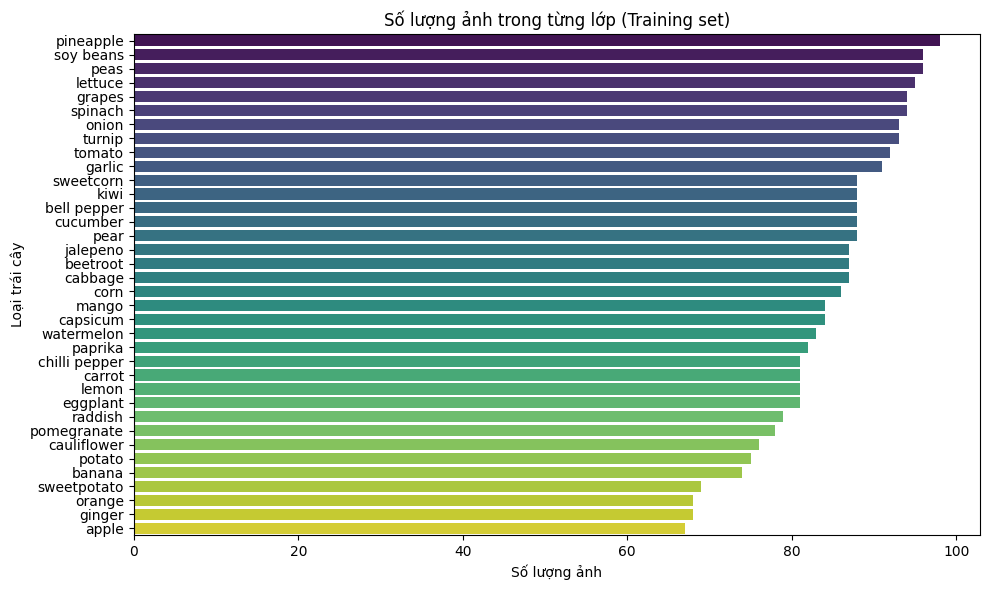

In [ ]:
# --- Biểu đồ phân bố ảnh theo lớp ---
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, y='Label', order=train_df['Label'].value_counts().index, palette='viridis')
plt.title("Số lượng ảnh trong từng lớp (Training set)")
plt.xlabel("Số lượng ảnh")
plt.ylabel("Loại trái cây")
plt.tight_layout()
plt.show()

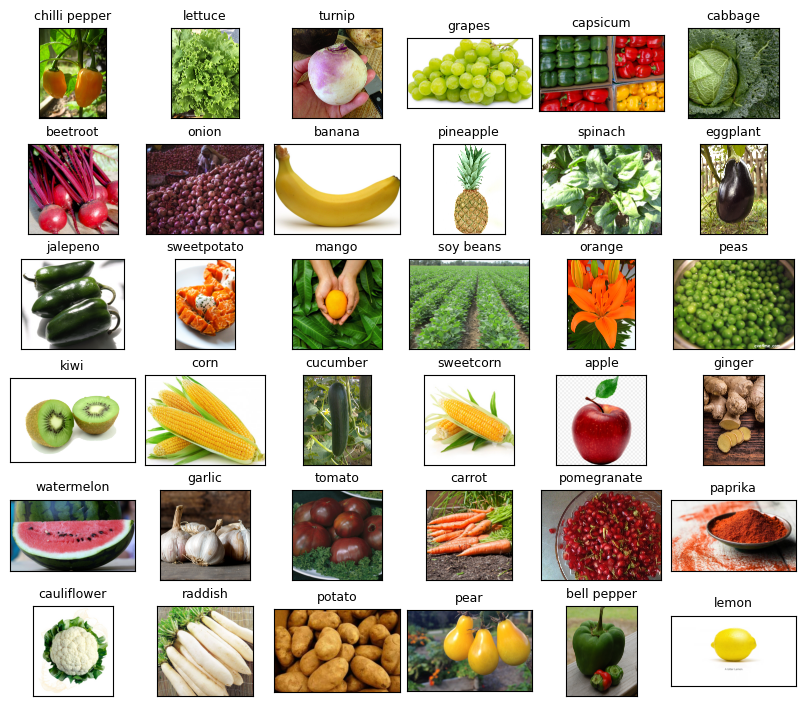

In [ ]:
# --- Hiển thị ảnh đại diện từng lớp (6x6) trong tập training data ---
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
rows, cols = 6, 6
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat[:len(df_unique)]):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=9)
plt.tight_layout(pad=0.5)
plt.show()

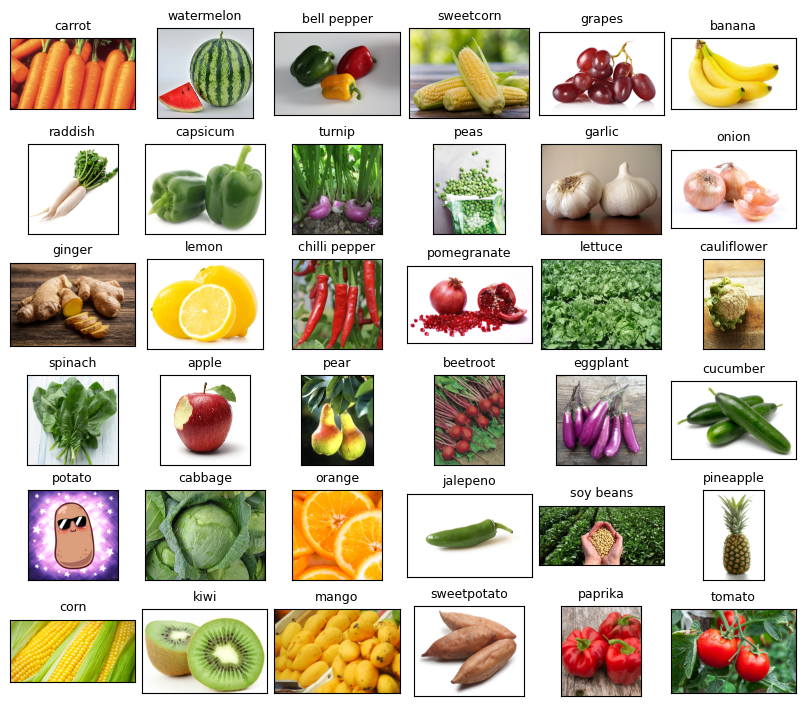

In [ ]:
# --- Hiển thị ảnh đại diện từng lớp (6x6) trong tập test data ---
df_unique = test_df.copy().drop_duplicates(subset=["Label"]).reset_index()
rows, cols = 6, 6
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat[:len(df_unique)]):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=9)
plt.tight_layout(pad=0.5)
plt.show()

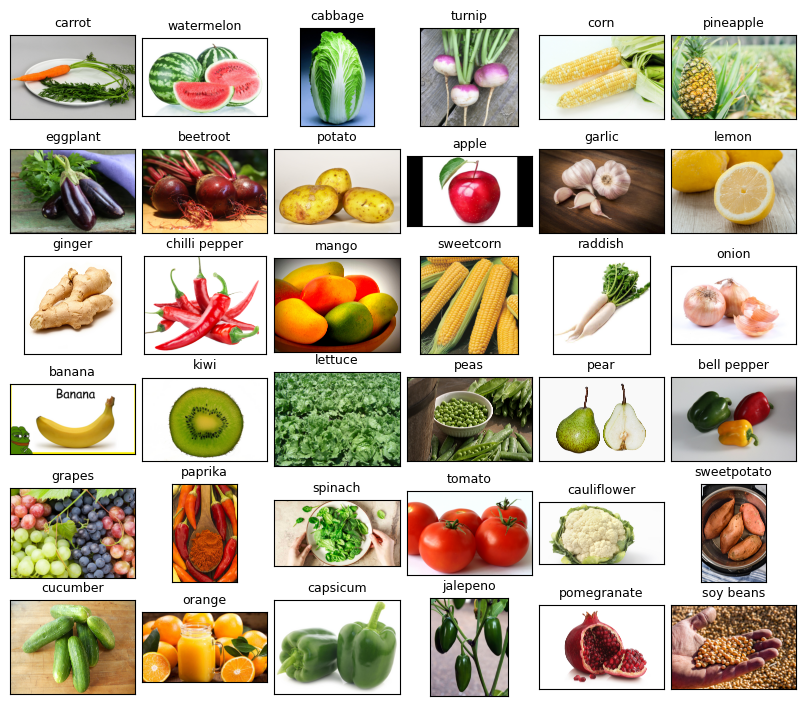

In [ ]:
# --- Hiển thị ảnh đại diện từng lớp (6x6) trong tập validation data ---
df_unique = val_df.copy().drop_duplicates(subset=["Label"]).reset_index()
rows, cols = 6, 6
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat[:len(df_unique)]):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=9)
plt.tight_layout(pad=0.5)
plt.show()

##1.5. Data Preprosessing and Image Generator

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3040 validated image filenames belonging to 36 classes.
Found 345 validated image filenames belonging to 36 classes.
Found 353 validated image filenames belonging to 36 classes.


## 1.6 Building and Training Model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,443,108 (9.32 MB)

 Trainable params: 185,124 (723.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.3746 - loss: 2.4578 - val_accuracy: 0.8899 - val_loss: 0.3773
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 929ms/step - accuracy: 0.8306 - loss: 0.5304 - val_accuracy: 0.9333 - val_loss: 0.2693
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 953ms/step - accuracy: 0.9127 - loss: 0.2992 - val_accuracy: 0.9188 - val_loss: 0.2461
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 941ms/step - accuracy: 0.9285 - loss: 0.2251 - val_accuracy: 0.9304 - val_loss: 0.2400
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9600 - loss: 0.1345 - val_accuracy: 0.9565 - val_loss: 0.1757


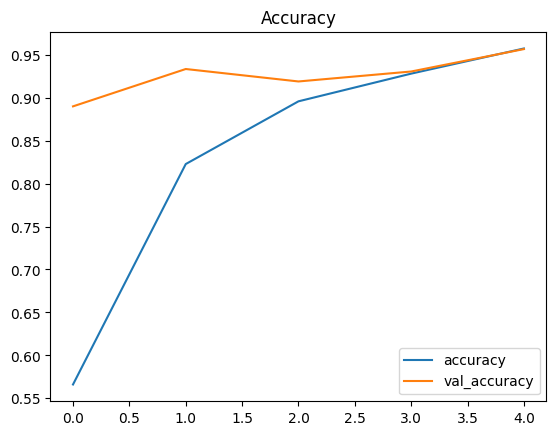

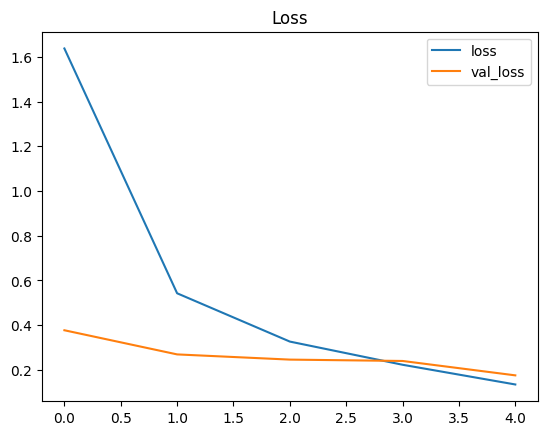

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

## 1.7. Evaluate and visualize results

12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step
Accuracy on the test set: 95.75%


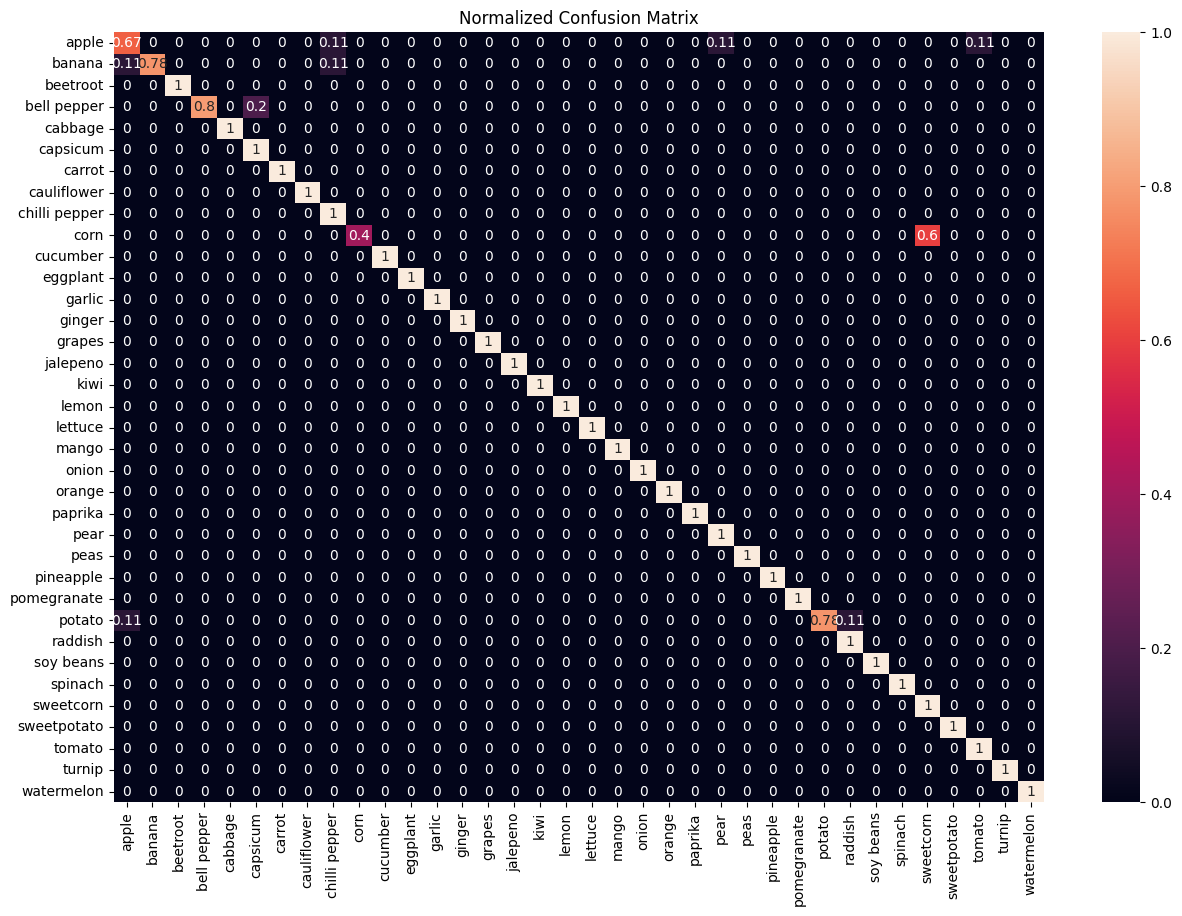

In [ ]:
# ==========================================
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]

acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()



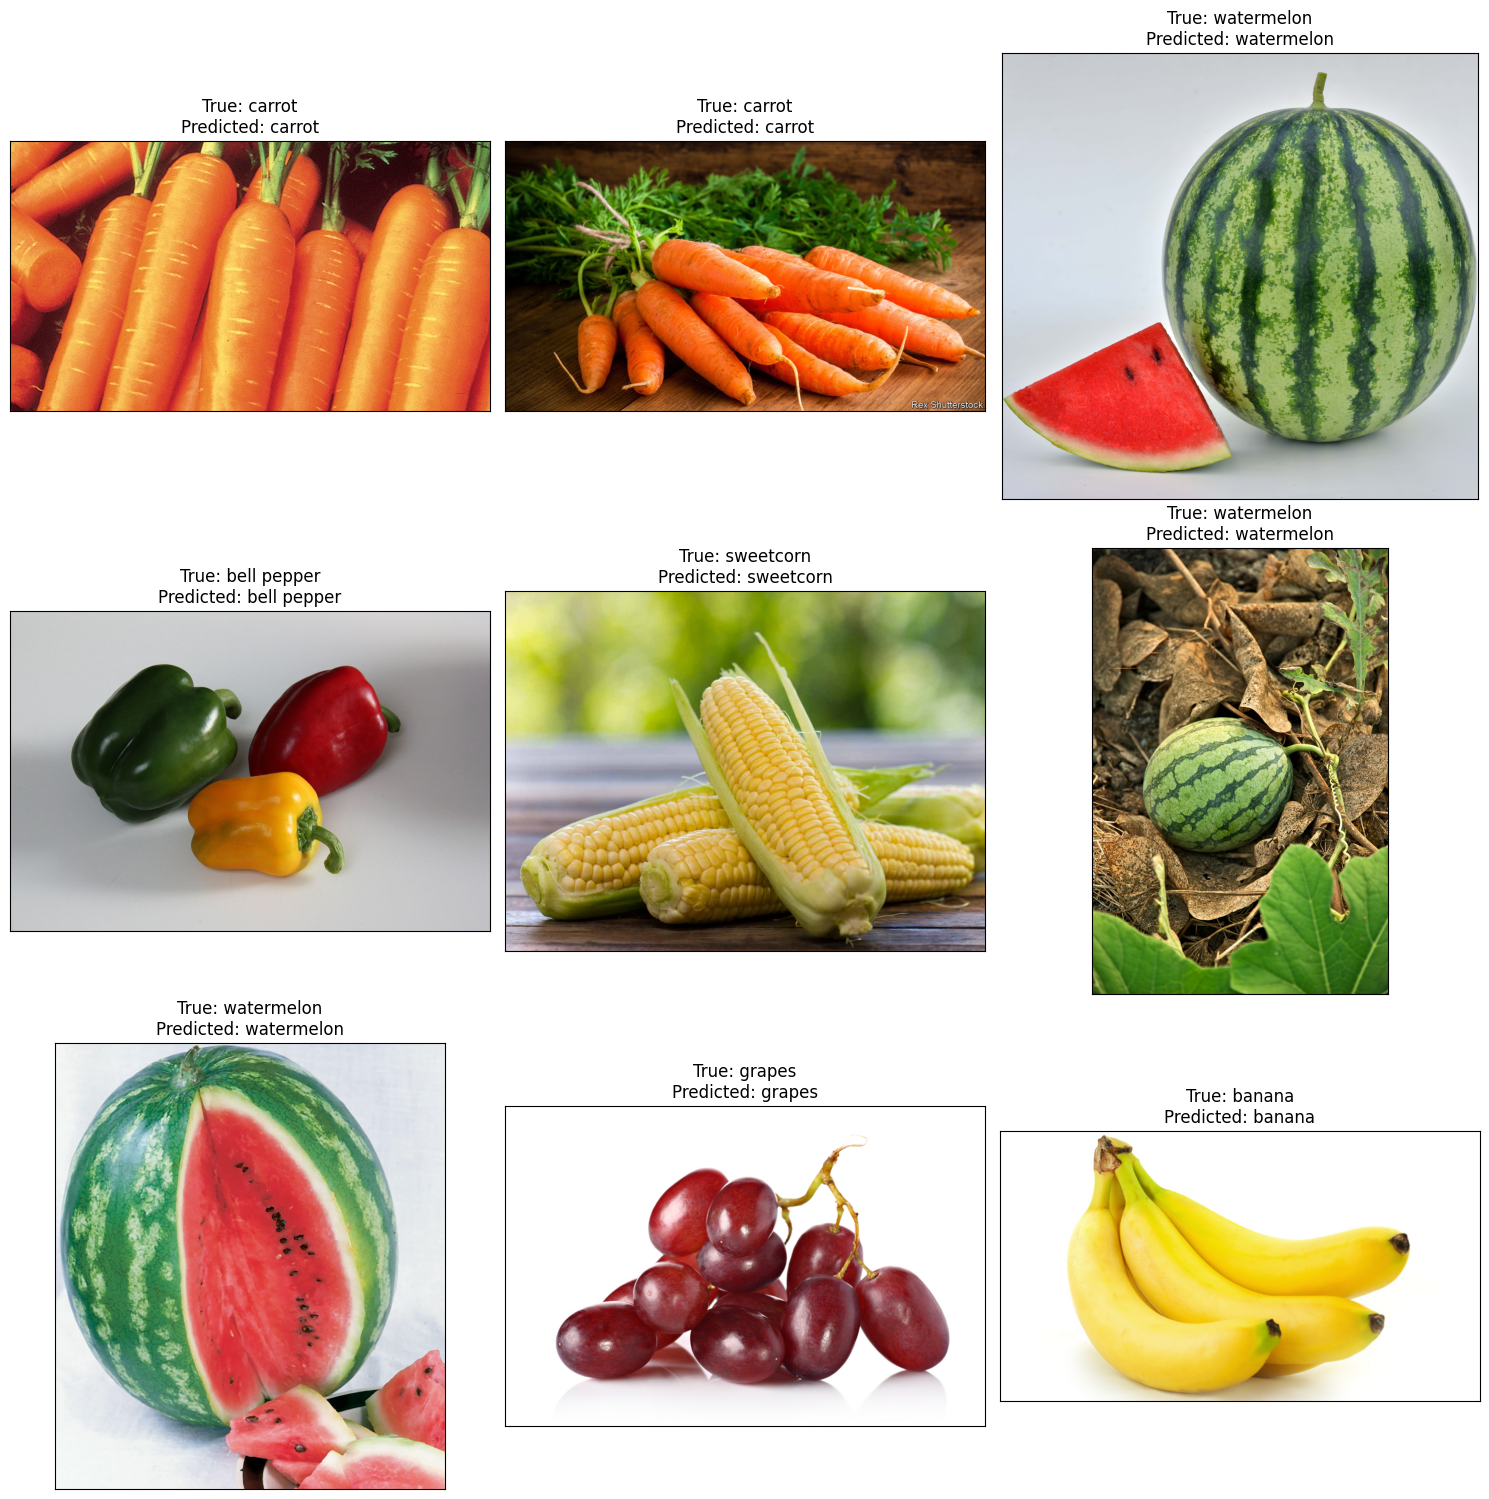

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## 1.8. Save model

In [ ]:

from google.colab import drive
import shutil, json

# Mount Google Drive
drive.mount('/content/drive')

# Tạo thư mục lưu model (bạn có thể đổi tên nếu muốn)
drive_path = "/content/drive/MyDrive/fruit_model"
!mkdir -p "$drive_path"

# Lưu model .h5
model.save("fruit_classifier_mobilenetv2.h5")
shutil.copy("fruit_classifier_mobilenetv2.h5", drive_path)

# Lưu file nhãn class_indices.json
json.dump(train_images.class_indices, open("class_indices.json", "w"))
shutil.copy("class_indices.json", drive_path)

print(" Model và class_indices.json đã được lưu vào Google Drive tại:")
print(drive_path)




Mounted at /content/drive


 Model và class_indices.json đã được lưu vào Google Drive tại:
/content/drive/MyDrive/fruit_model


# 2.Predict image process

## 2.1 Load saved model

In [ ]:


#  Bỏ xác thực SSL để tránh lỗi SSLCertVerificationError
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
ssl._create_default_https_context = ssl._create_unverified_context
import json
json.dump(train_images.class_indices, open("class_indices.json", "w"))

# 1. Load model đã lưu

drive_path = "/content/drive/MyDrive/fruit_model"
model = load_model(f"{drive_path}/fruit_classifier_mobilenetv2.h5")

# 2. Load file mapping class indices
with open("class_indices.json", "r") as f:
    labels = json.load(f)
labels = dict((v, k) for k, v in labels.items())

# (Tùy chọn) compile lại model để tránh warning về metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



## 2.2. Load & Preprocessn Image

In [ ]:
# 3. Ảnh từ Internet
img_url = "https://cdn.tienphong.vn/images/a6bf4f60924201126af6849ca45a398000817fa5dd6fb0c23f843852a5fadf4d388eb5da264f6a5483206e2d2336ead1b28cc64c3348226d87fd5b1ff0e9d17f/quakuu-yump-5287.jpg"  # <-- Thay link của bạn
response = requests.get(img_url, verify=False)
img = Image.open(io.BytesIO(response.content)).convert("RGB")
img = img.resize((224, 224))
img.save("web_image.jpg")  # lưu lại để Grad-CAM overlay

# 4. Tiền xử lý ảnh
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)




## 2.3. Model Prediction & Top-5 Results

In [ ]:
#  5. Dự đoán
pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)[0]
predicted_label = labels[predicted_class]

print(f"Predicted label: {predicted_label}\n")

#  6. In ra top-5 class có xác suất cao nhất
top5_idx = np.argsort(pred[0])[::-1][:5]
print("Top-5 predictions:")
for i in top5_idx:
    print(f"{labels[i]}: {pred[0][i]*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted label: pomegranate

Top-5 predictions:
pomegranate: 99.97%
tomato: 0.02%
apple: 0.01%
raddish: 0.00%
pineapple: 0.00%


## 2.4. Visualization Predict Result

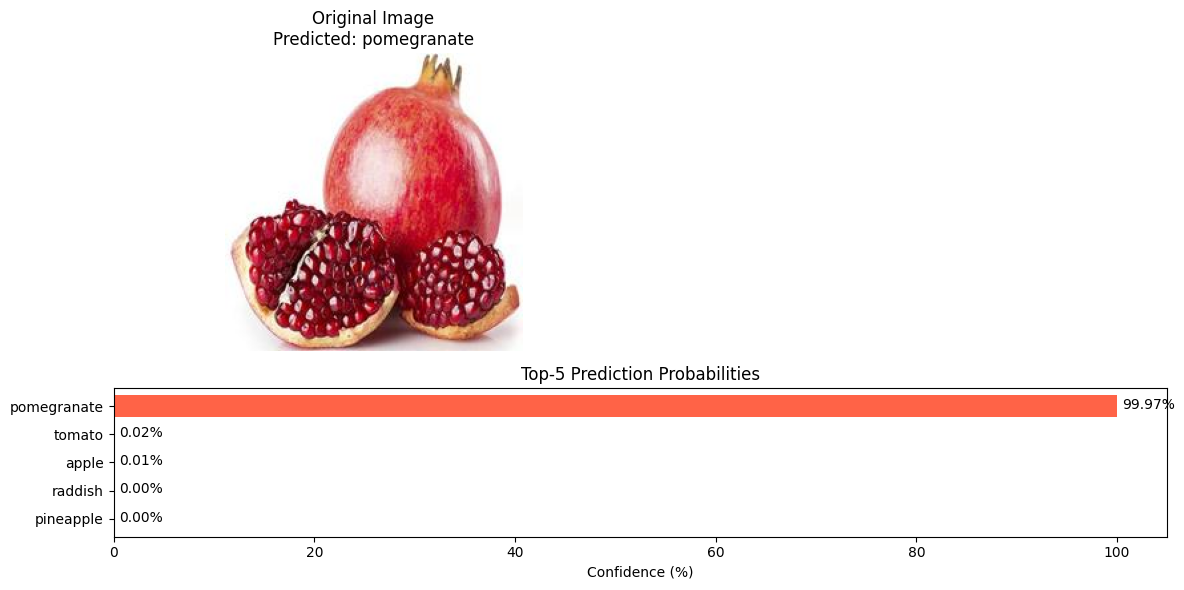

In [ ]:
# 9. Hiển thị kết quả
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])
# Ảnh gốc
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(Image.open("web_image.jpg"))
ax1.set_title(f"Original Image\nPredicted: {predicted_label}", fontsize=12)
ax1.axis("off")

# Biểu đồ xác suất (Top-5)
ax3 = fig.add_subplot(gs[1, :])
top5_labels = [labels[i] for i in top5_idx]
top5_probs = [pred[0][i]*100 for i in top5_idx]
bars = ax3.barh(top5_labels[::-1], top5_probs[::-1], color="tomato")
ax3.set_xlabel("Confidence (%)")
ax3.set_title("Top-5 Prediction Probabilities")
for bar in bars:
    ax3.text(bar.get_width()+0.5, bar.get_y()+0.3, f"{bar.get_width():.2f}%", fontsize=10)
plt.tight_layout()
plt.show()